# Music2Latent tests

<a href="https://colab.research.google.com/github/inspektral/onset-benchmark/blob/main/music2latent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [1]:
import os

if 'google.colab' in str(get_ipython()):
    repo_name = 'onset-benchmark'
    repo_path = f'/content/{repo_name}'
    
    # Check if the current working directory is already the repo
    if os.getcwd() != repo_path:
        if not os.path.exists(repo_path):
            !git clone https://github.com/inspektral/onset-benchmark.git
        os.chdir(repo_path)  # Change to the repository directory
        !pip install -r requirements.txt  # Install dependencies

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import synth
from IPython.display import Audio, display
import librosa

import utils
from music2latent import EncoderDecoder



/home/inspektral/miniconda3/envs/mir/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import test_signals

tests = {}

for name, obj in vars(test_signals).items():
    if callable(obj):
        tests[name] = obj

print("Available tests:")
for i, name in enumerate(tests.keys()):
    print(f"{i}: {name}")

Available tests:
0: random_sines
1: saw_noise
2: sines_noise


In [10]:
SAMPLE_RATE = 44100
CURRENT_TEST = 2

Running test: sines_noise


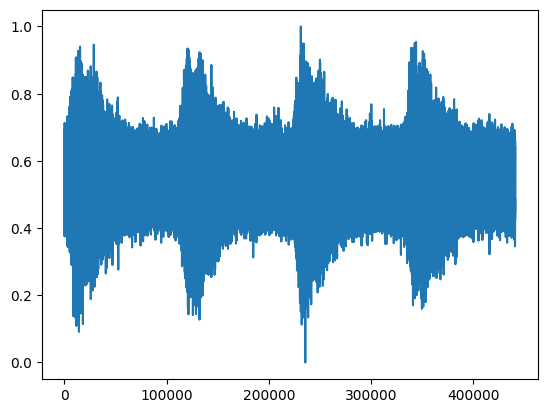

In [11]:
test = tests[list(tests.keys())[CURRENT_TEST]]
print(f"Running test: {test.__name__}")
audio = test(1)

plt.plot(audio)
plt.show()

display(Audio(audio, rate=SAMPLE_RATE))

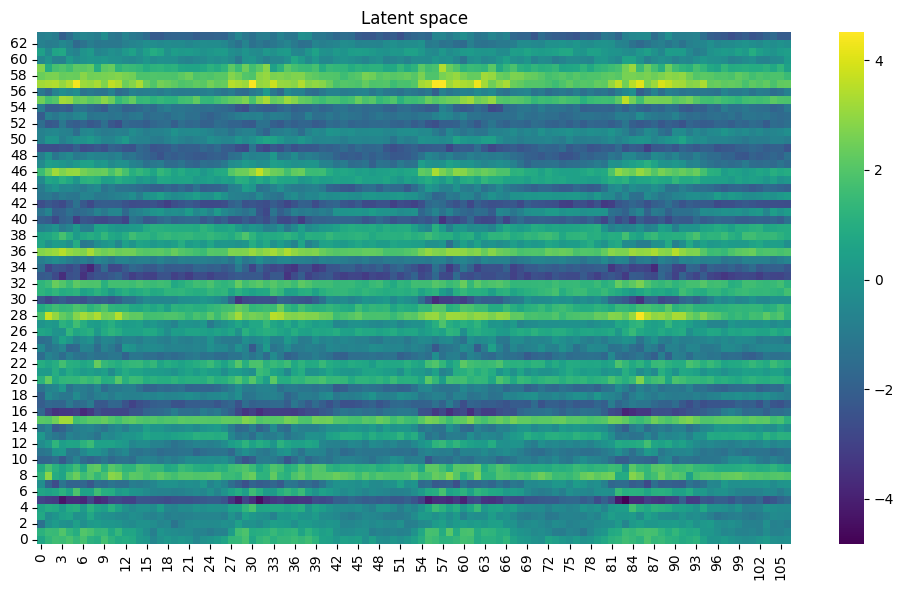

Reconstructed audio:


In [12]:
encdec = EncoderDecoder()
latent = encdec.encode(audio)
latent = latent.cpu().numpy()[0,:,:]
utils.plot_heatmap(latent, title="Latent space")

reconstructed = encdec.decode(latent)
print(f"Reconstructed audio:")
display(Audio(reconstructed, rate=SAMPLE_RATE))

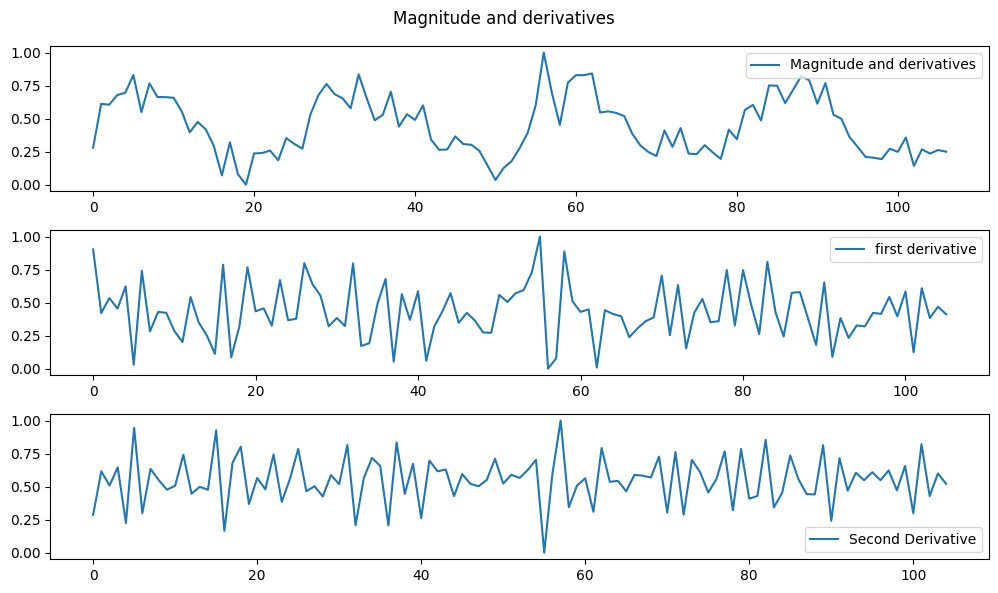

In [13]:

magnitude = np.sum(latent, axis=0)
d_magnitude = np.diff(magnitude)
dd_magnitude = np.diff(d_magnitude)

utils.plot_with_derivatives(
    magnitude,
    d_magnitude,
    dd_magnitude,
    title="Magnitude and derivatives",
)

distances shape: (64, 106)
max_indices: [ 5 13 49 30 41 39  7 47 40  6 24 20 21 56 34  9 28  8 37 59]


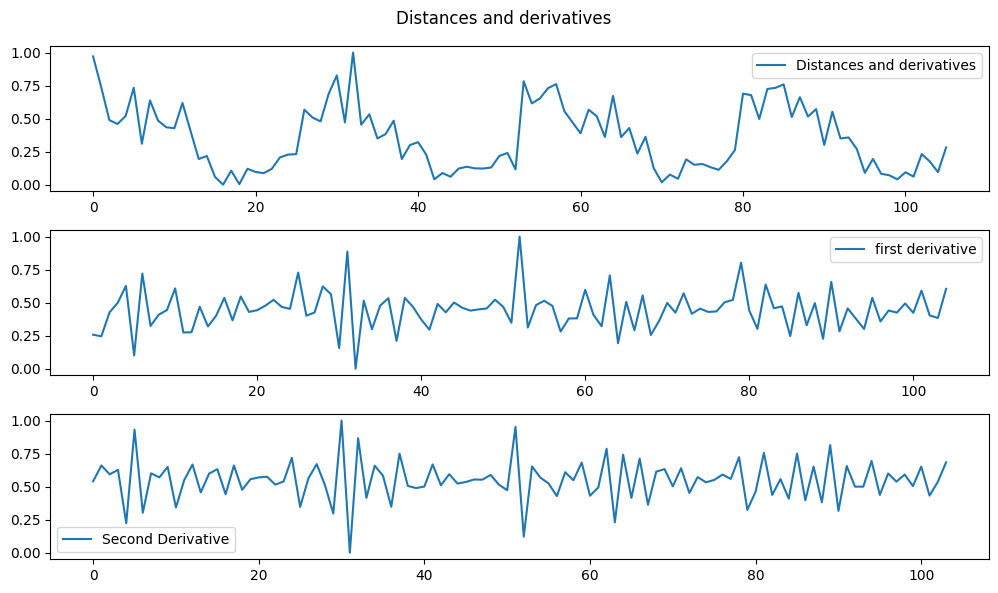

In [14]:
distances = utils.distances(latent, top_n=20)
d_distances = np.diff(distances)
dd_distances = np.diff(d_distances)

utils.plot_with_derivatives(
    distances,
    d_distances,
    dd_distances,
    title="Distances and derivatives",
)


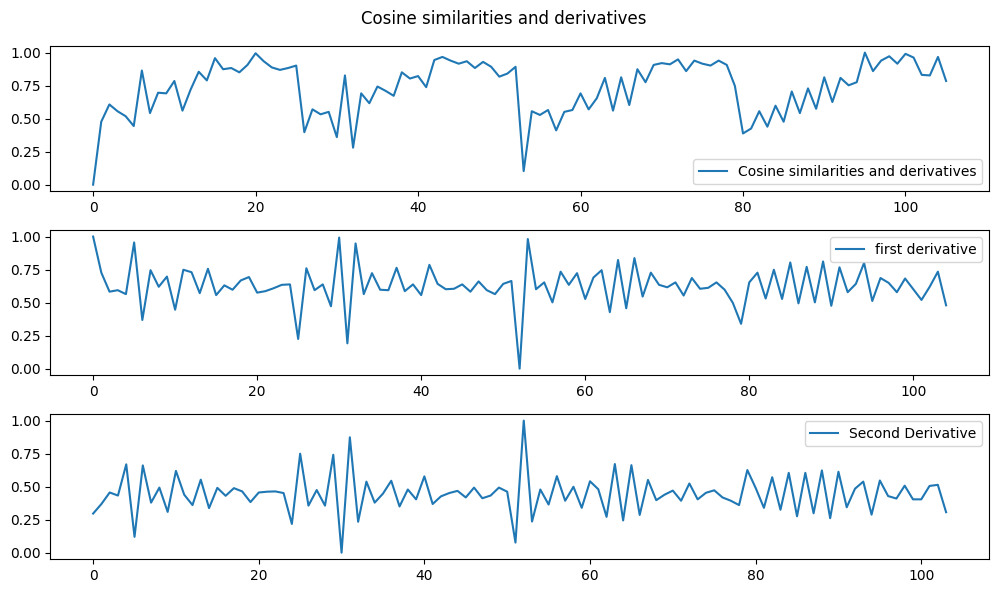

In [15]:
similarities = utils.cosine_similarity(latent)
d_similarities = np.diff(similarities)
dd_similarities = np.diff(d_similarities)

utils.plot_with_derivatives(
    similarities,
    d_similarities,
    dd_similarities,
    title="Cosine similarities and derivatives",
)